# Project 2
## Data Science 1 - Chinmay Agrawal

### 1. Introduction
I used my own dataset for this Project.

The data comes from https://www.gaujasoft.com/tabletorch/docs/vehicle-dataset/ . 

The data describes various cars involving their selling price, model, year built, the number of owner, mileage, and other metrics.

Column names: name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats

(When running report, run all cells past Regression again after pressing Run All initially)

In [1]:
#prepare tools for analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cars = pd.read_csv("Car details v3.csv").dropna().drop_duplicates()
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


### Pre-Processing
1. Removing columns irrelevant to us.
2. Removing any rows with missing values.
3. Outlier removal

In [2]:
# Let us create a seperate dataframe for the numerical columns and apply outlier detection
cars['mileage'] = cars['mileage'].str.extract('(\d+\.\d+)').astype(float)
cars['engine'] = cars['engine'].str.replace(' CC', '').astype(float)
cars['max_power'] = cars['max_power'].str.extract('(\d+(\.\d+)?)')[0].astype(float)


numerical=cars[['year','selling_price','km_driven','mileage', 'engine', 'max_power']]


#function for outlier detection
def is_outlier(x):
    Q25, Q75 = x.quantile([.25,.75])
    I = Q75 - Q25
    return (x < Q25 - 1.5*I) |  (x > Q75 + 1.5*I)

outliers = numerical.apply(is_outlier)

# Now to remove the outliers
cars = cars[~outliers.any(axis=1)]

#Removing irrelevant columns


cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


## 2. Classification

Question: Can we predict what number owner (first,second,third, etc.) a car is based on the Selling Price, year of manufactoring, mileage, kilometers driven, and number of seats?

Note: We will be using F1 Scores as a measure of performance which is the harmonic mean of the precision and the recall. This is because Balancing errors is important to us since false positives and false negatives carry significant implications. In our case they can incorrectly predicting a car as being a newer hand or  Incorrectly predicting a car as being an older hand resulting in undervaluation which are both relevant.

In [3]:
#Splitting data into training and testing sets
from sklearn.model_selection import train_test_split
X = cars[['selling_price','year','mileage','km_driven','seats']]
y = cars['owner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

We will perform a grid search with training data on both kNN and decision trees across various hyperparameters.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler   # converts to z-scores
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#KNN Classifier with various hyperparameters
grid = { "kneighborsclassifier__metric":["euclidean", "manhattan"], 
         "kneighborsclassifier__n_neighbors":range(1, 20), 
         "kneighborsclassifier__weights":["uniform", "distance"] }

learner = make_pipeline(StandardScaler(), KNeighborsClassifier())

kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=302)

grid_knn = GridSearchCV(
    learner, grid, 
    scoring="f1_weighted", 
    cv=kf,
    n_jobs=-1
    )
grid_knn.fit(X_train, y_train)

print("Best parameters:")
print(grid_knn.best_params_)
print()
print("Best score:")
print(grid_knn.best_score_)

Best parameters:
{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__weights': 'uniform'}

Best score:
0.632882105299208


We used a KNN Neighbour Classifier and k=4 yields the best score using the the Manhatten Metric with Distance weight.

In [5]:
#Performing a Grid Search with KNN and Descision Trees:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold


#Decision Tree Classifier
kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=302)

grid = { "criterion":["gini", "entropy"], 
         "max_depth":range(2, 15), 
           }
learner = DecisionTreeClassifier(random_state=19716)

grid_search =  GridSearchCV(
    learner, grid, 
    scoring="f1_weighted", 
    cv=kf,
    n_jobs=-1
    )

grid_search.fit(X_train, y_train) 

tree_best_params = grid_search.best_params_
tree_best_score = grid_search.best_score_

print("Best parameters:")
print(tree_best_params)
print()
print(f"Best score is {tree_best_score:.4f}")

Best parameters:
{'criterion': 'gini', 'max_depth': 2}

Best score is 0.6470


### Initial Analysis

We used a Descision Tree Classifier with hyperparameters such as Criterion and Maximum depth of the Tree. Based on the various Trees, we see the best score is yielded when Gini is used for Criterion and a Maximum Depth of 2. We see the F1 Weighted Score using KNN with k=19 to be 0.633 whearas the score from the best tree is 0.647 yielding a better result.

Now, lets see the best features using our Best Tree.

In [6]:
from sklearn.metrics import accuracy_score

#We define the classifier with the best parameters as found above
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=2)
dt_classifier.fit(X_train, y_train)
predictions = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

feature_columns = ['selling_price','year','mileage','km_driven','seats']
feature_importances = pd.DataFrame(dt_classifier.feature_importances_,
                                   index = feature_columns,
                                   columns=['importance']).sort_values('importance', ascending=True)

print(feature_importances)



               importance
selling_price    0.000000
mileage          0.000000
seats            0.000000
km_driven        0.139152
year             0.860848


From this, we see that the year of the make of the car along with the Kilometers driven are the first and second most important features when determining what 'hand' of ownership a car is.

### Let us now use an Esemble Method, particularly a Random Forest Classifier to make a validation curve as a function of the max ensemble sample size.

F₁ for max_samples = 0.1 is 0.6320
F₁ for max_samples = 0.2 is 0.6330
F₁ for max_samples = 0.3 is 0.6305
F₁ for max_samples = 0.4 is 0.6274
F₁ for max_samples = 0.5 is 0.6269
F₁ for max_samples = 0.6 is 0.6246
F₁ for max_samples = 0.7 is 0.6181
F₁ for max_samples = 0.8 is 0.6324
F₁ for max_samples = 0.9 is 0.6198
F₁ for max_samples = 1.0 is 0.6172


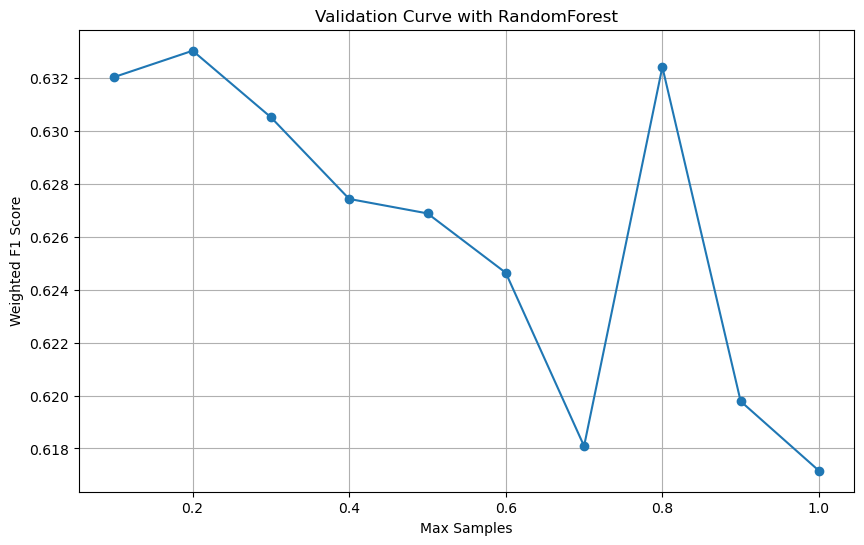

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

max_samples_range = np.linspace(0.1, 1.0, 10)

# Store F1 scores for each value of max_samples
f1_scores = []

for max_samples in max_samples_range:
    rf = RandomForestClassifier(
        max_depth=24, 
        max_samples=max_samples,
        n_estimators=100, 
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    F1 = f1_score(y_test, rf.predict(X_test), average='weighted')
    f1_scores.append(F1)
    print(f"F₁ for max_samples = {max_samples:.1f} is {F1:.4f}")

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.plot(max_samples_range, f1_scores, marker='o')
plt.title('Validation Curve with RandomForest')
plt.xlabel('Max Samples')
plt.ylabel('Weighted F1 Score')
plt.grid(True)
plt.show()

In [8]:
max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)
max_f1_sample = max_samples_range[max_f1_index]

print(f"The maximum F₁ score is {max_f1:.4f} at max_samples = {max_f1_sample:.1f}")

The maximum F₁ score is 0.6330 at max_samples = 0.2


### Comparing the Best classifiers.
Best KNN Classifier with Best parameters:{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__weights': 'uniform'} and the Best score: 0.632882105299208

Best Descision Tree Classifier with Best parameters: {'criterion': 'gini', 'max_depth': 2} and Best score is 0.6470

Best Ensemble Method (Random Forest Classifier) with best F1 score  as 0.6299 when Max Samples = 0.9

Therefore, we see from the above three, that the Descision Tree Classifier is the Best Overall. Let us now plot an ROC curve for it.

c:\Users\sande\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


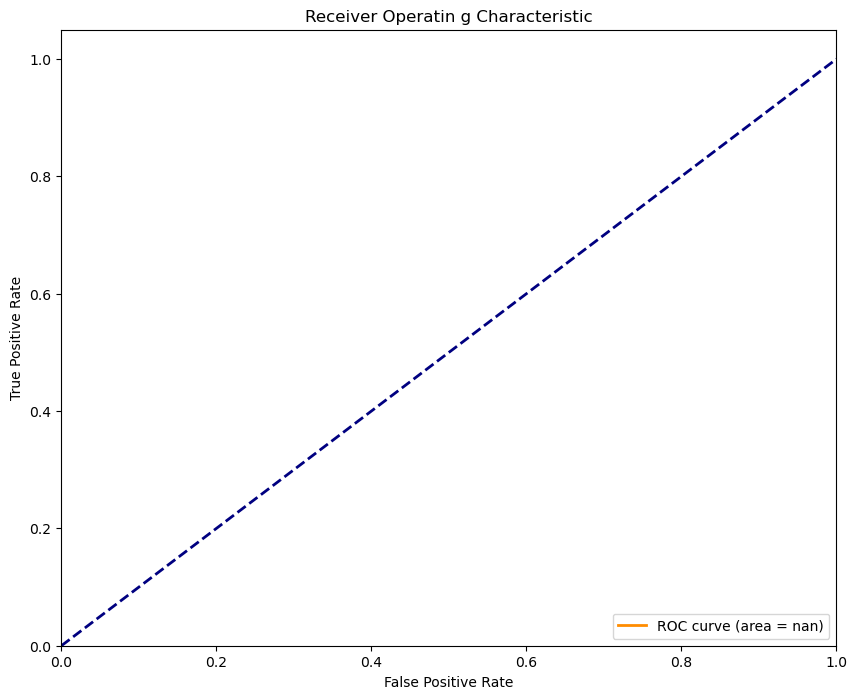

In [9]:
from sklearn.metrics import roc_curve, auc

probability= dt_classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probability, pos_label='satisfied')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operatin g Characteristic')
plt.legend(loc="lower right")
plt.show()

## 2. Regression
Question: Can Selling Price of Car be determined based off of Mileage, Engine, Seats, Kilometers Driven and Max Power.

Note: We will be using Coefficient of Determination as a measure of performance.

### a) Ridge Regression

alpha = 0.25
2-norm of coefficient vector: 60050.0
ridge regression CoD score: 0.6617

alpha = 0.50
2-norm of coefficient vector: 60032.5
ridge regression CoD score: 0.6617

alpha = 1.00
2-norm of coefficient vector: 59997.6
ridge regression CoD score: 0.6617

alpha = 2.00
2-norm of coefficient vector: 59928.2
ridge regression CoD score: 0.6617



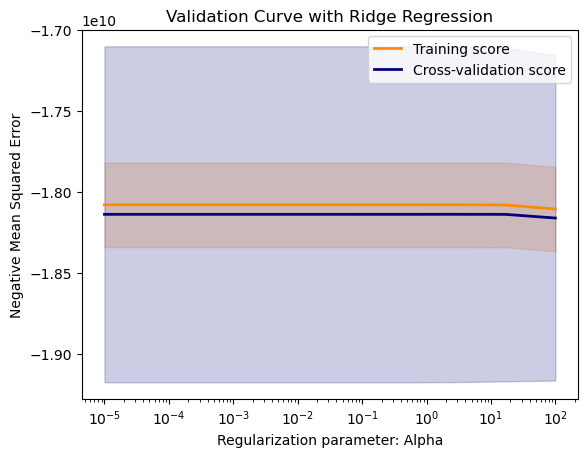

Most positive influence: 1
Most negative influence: 3


In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import validation_curve
from numpy.linalg import norm


# Convert the owner column to integers
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3
}
cars['owner'] = cars['owner'].map(owner_mapping).fillna(4).astype(int)
cars['fuel'] = np.where(cars['fuel'] == 'Petrol', 1, 0)

X = cars[['owner','year','mileage','km_driven','engine','seats','fuel']]
y = cars['selling_price']


# Assuming X and y are your data and labels respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for alpha in [0.25, 0.5, 1, 2]:
    rr = Ridge(alpha=alpha)    # more regularization
    rr.fit(X_train, y_train)
    print(f"alpha = {alpha:.2f}")
    print(f"2-norm of coefficient vector: {norm(rr.coef_):.1f}")
    print(f"ridge regression CoD score: {rr.score(X_test, y_test):.4f}")
    print()


# Create a Ridge regression model within a pipeline that first standardizes the data
model = make_pipeline(StandardScaler(), Ridge())

# Define range of alpha values for Ridge regularization parameter
param_range = np.logspace(-5, 2, 10)

# Compute validation curve
train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="ridge__alpha", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)

# Calculate mean and standard deviation for train and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
plt.semilogx(param_range, train_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="darkorange", alpha=0.2)
plt.semilogx(param_range, test_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="navy", alpha=0.2)
plt.title("Validation Curve with Ridge Regression")
plt.xlabel("Regularization parameter: Alpha")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.show()


chosen_alpha = 0.5  # value chosen based off best 2-norm of coefficient vector
model.set_params(ridge__alpha=chosen_alpha)
model.fit(X_train, y_train)

# Retrieve the coefficients to see influence
coefficients = model.named_steps['ridge'].coef_

# Show which columns have the greatest positive and negative influence
print("Most positive influence:", np.argmax(coefficients))
print("Most negative influence:", np.argmin(coefficients))

We see that the 'Hand' of the Ownership of the car has the most significant impact whearas the Mileage has the least significant impact on the Selling Price of a Car.

### LASSO Regression

In [11]:
from sklearn.linear_model import Lasso

alpha = np.linspace(0, 0.1, 60)[1:]  # exclude alpha=0

lass = Lasso(alpha=0.05)
lass.fit(X_train, y_train)
pd.DataFrame( {
    "feature": X.columns,
    "ridge": rr.coef_,
    "LASSO": lass.coef_
    } )



,feature,ridge,LASSO
0,owner,-15934.297811,-15951.690823
1,year,37942.974938,37946.450358
2,mileage,2656.805710,2638.420238
3,km_driven,-0.839163,-0.839631
4,engine,384.265161,384.034592
5,seats,14428.879485,14423.412927
6,fuel,-41017.319117,-41213.158828


In [12]:

# Get the locations (indices) of the very small weights:
zeroed = np.nonzero( np.abs(lass.coef_) < 1e-5 )
# Names of the corresponding columns:
dropped = X.columns[zeroed].values
print(dropped)

[]


Based on this, We see that the owner and fuel columns should be dropped.

In [13]:
from sklearn.linear_model import LinearRegression

dropped=['owner','fuel']
X_train_reduced = X_train.drop(dropped, axis=1)
X_test_reduced = X_test.drop(dropped, axis=1)

lass.fit(X_train_reduced,y_train)
print(f"CofD score with reduced features: {lass.score(X_test_reduced, y_test):.4f}")


CofD score with reduced features: 0.6558


### Grid Search for a nonlinear regressor (decision tree)

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits=6, shuffle=True, random_state=3383)
grid = {
    "kneighborsregressor__n_neighbors": range(2, 25),
    "kneighborsregressor__weights": ["uniform", "distance"] 
    }
knn = make_pipeline( StandardScaler(), KNeighborsRegressor() )
optim = GridSearchCV(
    knn, grid, 
    cv=kf, 
    n_jobs=-1
    )

optim.fit(X_train, y_train)

print(f"best kNN CoD: {optim.score(X_test, y_test):.4f}")

best kNN CoD: 0.7911


### A quick Comparision

Looking at all of the Coefficient of Determination scores will help us determine the best regressor.
Ridge Regression yielded a CofD of 0.4636
LASSO Regression yielded a CofD of 0.4636 as well.
Grid Search using Descision Tree yielded a CofD of 0.7989 making it the best Classifier.

# Discussion

In Both cases, we see that a Descision Tree yielded the best result using Classification and Regression methods.

We see the that the most relevant features within the dataset were Selling_price and Ownership were the most significant whearas Fuel Type was the least relevant.

Future Potential Features include:
1. Accident History: A car that has been in major accidents is likely to be valued less than a similar car with a clean history.
2. Vehicle Condition: A car that is in excellent condition with minimal wear and tear is usually more attractive to buyers and can command a higher price. This can be a rating scale from 1-10 with 10 as Brand as New and 1 as Borderline Junk.


-------------------------------------------------------------------o-------------------------------------------------------------------